In [19]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Dataset directories
training_dir = "data/Training"
testing_dir = "data/Testing"

# Processed data directories
processed_training_dir = "data/Processed/Training"
processed_testing_dir = "data/Processed/Testing"


# Class names
classes = ['glioma', 'meningioma', 'notumor']

In [20]:
def load_images_from_class(dataset_path, class_name, num_samples=3):
    """
    Loads up to num_samples images from the specified class folder in dataset_path.
    Returns a list of tuples: (image_file_path, image_array)
    """
    class_dir = os.path.join(dataset_path, class_name)
    image_files = [os.path.join(class_dir, f) for f in os.listdir(class_dir)]
    image_files = image_files[:num_samples]
    images = []
    for image_file in image_files:
        img = cv2.imread(image_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if img is not None:
            images.append((image_file, img))
    return images


def plot_samples(dataset_path):
    """
    Plots sample images
    """
    plt.style.use('default')
    fig, axs = plt.subplots(len(classes), 3, figsize=(7, 7))
    for i, class_name in enumerate(classes):
        images = load_images_from_class(dataset_path, class_name, num_samples=3)
        for j, (img_path, img) in enumerate(images):
            axs[i, j].imshow(img, cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title(f"{class_name}\n{os.path.basename(img_path)}\nSize: {img.shape}")
    plt.tight_layout()
    plt.show()


def get_image_size_statistics(dataset_path):
    """
    Computes and prints average dimensions for each class in the specified dataset_path.
    """
    for class_name in classes:
        class_dir = os.path.join(dataset_path, class_name)
        image_files = [os.path.join(class_dir, f) for f in os.listdir(class_dir)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        sizes = []
        for image_file in image_files:
            img = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                sizes.append(img.shape)
        if sizes:
            sizes = np.array(sizes)
            avg_height = np.mean(sizes[:, 0])
            avg_width = np.mean(sizes[:, 1])
            print(f"Class '{class_name}': {len(sizes)} images, Average Size: {avg_height:.2f} x {avg_width:.2f}")
        else:
            print(f"Class '{class_name}': No images found.")


def preprocess_image(img, target_size, noise_kernel=(5, 5), clahe_clip=2.0, block_size=11, C=2):
    """
    Applies Gaussian blur for noise reduction, CLAHE for contrast enhancement,
    and adaptive thresholding to segment and crop the image. Finally, the image is resized.
    """
    # Noise reduction via Gaussian blur
    blurred = cv2.GaussianBlur(img, noise_kernel, 0)
    # Contrast enhancement with CLAHE
    clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=(8, 8))
    enhanced = clahe.apply(blurred)
    # Adaptive thresholding using Gaussian method
    thresh = cv2.adaptiveThreshold(enhanced, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, block_size, C)
    # Check if threshold image is nearly all white; if so, invert it
    if np.sum(thresh == 255) > 0.9 * thresh.size:
        thresh = cv2.bitwise_not(thresh)
    # Find non-zero pixels in the threshold mask
    coords = cv2.findNonZero(thresh)
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)
        cropped = img[y: y + h, x: x + w]
        processed = cv2.resize(cropped, target_size)
    else:
        processed = cv2.resize(img, target_size)
    return processed



def create_processed_dirs(base_output_dir):
    for class_name in classes:
        class_path = os.path.join(base_output_dir, class_name)
        os.makedirs(class_path, exist_ok=True)

def process_and_save_images(input_dir, output_dir, target_size, enhancement_params):
    for class_name in classes:
        input_class_dir = os.path.join(input_dir, class_name)
        output_class_dir = os.path.join(output_dir, class_name)
        os.makedirs(output_class_dir, exist_ok=True)
        image_files = [f for f in os.listdir(input_class_dir)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        for file in image_files:
            input_path = os.path.join(input_class_dir, file)
            img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            processed_img = preprocess_image(img, target_size, **enhancement_params)
            output_path = os.path.join(output_class_dir, file)
            cv2.imwrite(output_path, processed_img)


Original Training Data Statistics:
Class 'glioma': 1321 images, Average Size: 512.00 x 512.00
Class 'meningioma': 1339 images, Average Size: 495.23 x 493.39
Class 'notumor': 1595 images, Average Size: 320.73 x 313.95

Original Training Data Samples:


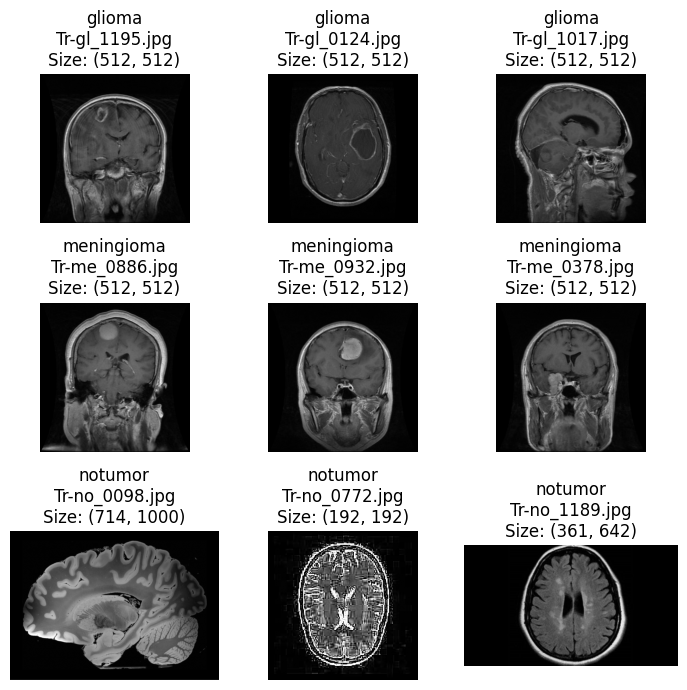


Processed Training Data Samples:


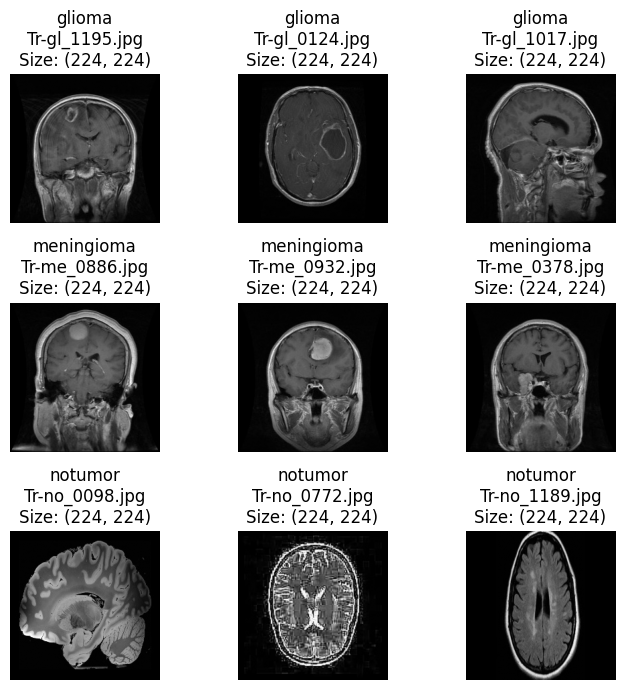

In [21]:
create_processed_dirs(processed_training_dir)
create_processed_dirs(processed_testing_dir)

# Visualizing original training data
print("\nOriginal Training Data Statistics:")
get_image_size_statistics(training_dir)
print("\nOriginal Training Data Samples:")
plot_samples(training_dir)

# Parameters for enhancement processing
enhancement_params = {
    "noise_kernel": (5, 5),
    "clahe_clip": 2.0,
    "block_size": 11,
    "C": 2
}

# Process and save the images
process_and_save_images(training_dir, processed_training_dir, target_size=(224, 224), enhancement_params=enhancement_params)
process_and_save_images(testing_dir, processed_testing_dir, target_size=(224, 224), enhancement_params=enhancement_params)

# Visualizing processed training data
print("\nProcessed Training Data Samples:")
plot_samples(processed_training_dir)